# Whale categorization: baseline

In [6]:
## All imports needed
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from fastai.column_data import *
from fastai.structured import *

import seaborn as sns
from tqdm import tqdm

import pandas as pd
import numpy as np

from tqdm import tqdm, tqdm_pandas
from pathlib import Path
import dill as pickle
from matplotlib import patches, patheffects
tqdm.pandas()

In [7]:
PATH = Path('/home/paperspace/.kaggle/competitions/whale-categorization-playground/')

In [4]:
# # Data load - only needed the first time, uncomment to run
# ! kaggle competitions download -c whale-categorization-playground
# ! cd {PATH} && unzip -o test.zip > /dev/null
# ! cd {PATH} && unzip -o train.zip > /dev/null

# train_df = pd.read_csv(PATH/'train.csv')
# train_df['Id'] = train_df['Id'].astype('category')
# whale_ids = train_df['Id'].unique()
# whale_ids2num = {k: v for k,v in zip(whale_ids, range(len(whale_ids)))}
# train_df['Id'] = train_df['Id'].map(whale_ids2num)
# train_df.to_csv(PATH/'train.csv', index=False)
# pickle.dump(whale_ids2num, open('whale_ids2num.pkl', 'wb'))

In [8]:
train_df = pd.read_csv(PATH/'train.csv')
whale_ids2num = pickle.load(open('whale_ids2num.pkl', 'rb'))

In [9]:
f_model = resnet34
sz = 224
bs = 64 # 256 exhausts memory on paperspace machine P4000

# Define our data augmentation
augs = [
    RandomFlip(),
    RandomLighting(0.1, 0.1),
    RandomRotate(3)
]

tfms = tfms_from_model(f_model, sz, aug_tfms=augs, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(PATH, 'train', PATH/'train.csv', tfms=tfms, bs=bs, test_name='test')

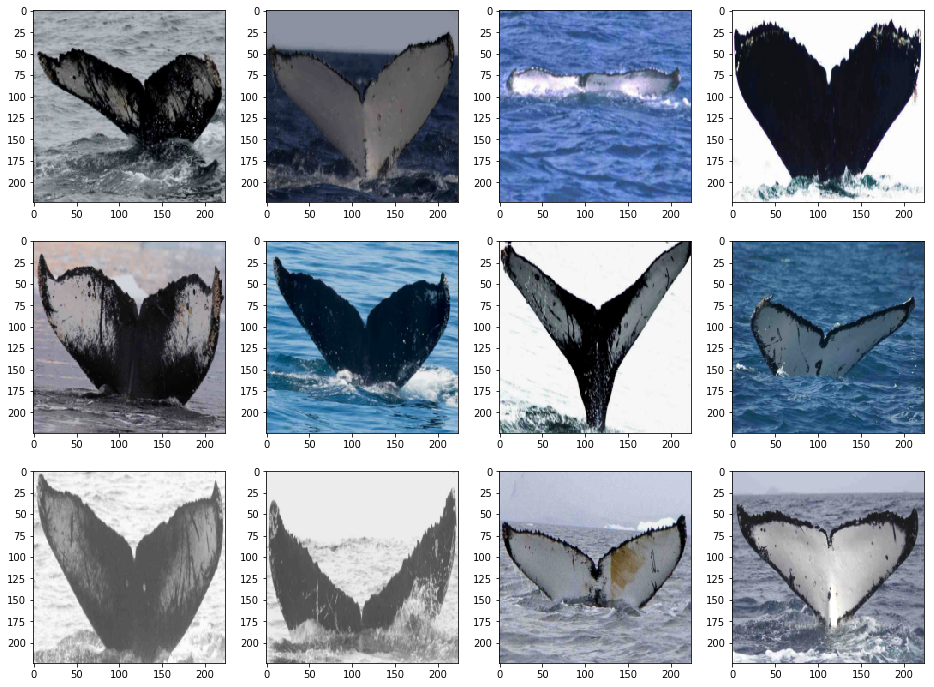

In [10]:
xs,ys = next(iter(md.trn_dl))
xs = xs[:12]
ys = ys[:12]

fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for x, y, i in zip(xs, ys, range(16)):
    ax = axes.flat[i]
    img = md.trn_ds.denorm(to_np(x)).squeeze()
    ax.imshow(img)

In [11]:
learn = ConvLearner.pretrained(f_model, md)
learn.opt_fn = optim.Adam

 84%|████████▍ | 104/124 [00:32<00:06,  3.21it/s, loss=41.3]

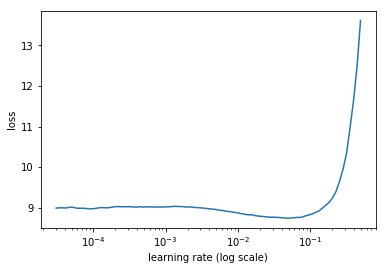

In [7]:
learn.lr_find()
learn.sched.plot()

In [8]:
# Define the MPA@5 metric
def mpa_at_k(probs, y, k):
    probs_sorted = np.argsort(-probs,axis=1)[:,:k] # Only interested in the top 5
    matches = np.array([a == b for a,b in zip(probs_sorted,y)])
    return np.sum(matches * np.array([[1.0/x for x in range(1,k+1)]])) / len(y)

def mpa_at_5(probs, y):
    return mpa_at_k(probs, y, 5)

def mpa_at_5_pyt(probs, y):
    probs = probs.cpu().numpy()
    return mpa_at_5(probs, y)

In [9]:
lr = 1e-2

learn.fit(lr, 2, cycle_len=1, cycle_mult=2, metrics=[mpa_at_5_pyt])
learn.save('frozen')

  0%|          | 0/124 [00:00<?, ?it/s]
epoch      trn_loss   val_loss   mpa_at_5_pyt               
    0      8.135532   7.693851   0.089729  
    1      7.368984   7.603789   0.13242                    
    2      5.692008   7.450948   0.148519                   



 81%|████████▏ | 101/124 [00:47<00:10,  2.15it/s, loss=24.5]

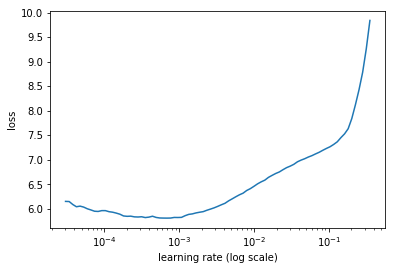

In [10]:
learn.load('frozen')
learn.freeze_to(-2)
learn.lr_find()
learn.sched.plot()

In [12]:
lr = 1e-4
lrs = np.array([lr/6,lr/3,lr]) # We want to train lower layers a fair bit to specialise towards whale-tail specific features
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2, best_save_name='nn2_', metrics=[mpa_at_5_pyt])
learn.save('unfrozen1')

  9%|▉         | 11/124 [00:06<01:01,  1.83it/s, loss=5.5]
epoch      trn_loss   val_loss   mpa_at_5_pyt               
    0      5.397612   7.470803   0.144019  
    1      5.163499   7.39758    0.153536                   
    2      4.899456   7.371924   0.157538                   



## Make a submission

In [12]:
learn.load('unfrozen1')
probs, _ = learn.TTA(is_test=True)

In [13]:
# Assemble our data frame
mean_probs = np.mean(probs, axis=0) # Average probs from TTA
probs_sorted = np.argsort(-mean_probs,axis=1)[:,:5] # Get top 5 predictions

fnames = [f[5:] for f in md.test_ds.fnames] # get rid of folder prefix

num2whale = [k for k,v in whale_ids2num.items()]

def probs2whale(x):
    return num2whale[int(md.classes[x])]

probs2whale = np.vectorize(probs2whale)

def join_with_spaces(arr):
    return ' '.join(arr)

whales = np.apply_along_axis(join_with_spaces, 1, probs2whale(probs_sorted))

In [14]:
df = pd.DataFrame({'Image': fnames, 'Id': whales}, columns=['Image','Id'])
df.to_csv(PATH/'submission.csv', index=False)

In [15]:
! kaggle competitions submit -c whale-categorization-playground -f {PATH}/submission.csv -m 'baseline_2'

Successfully submitted to Humpback Whale Identification Challenge